In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

url = ("https://hbiostat.org/data/repo/titanic3.csv")

df = pd.read_csv(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


In [2]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [3]:
y_pred = dt.predict(X_test)

tp=(
    (y_test == 1) & (y_test == y_pred)
).sum()

tn=(
    (y_test == 0) & (y_test == y_pred)
).sum()

fp=(
    (y_test == 0) & (y_test != y_pred)
).sum()

fn=(
    (y_test == 1) & (y_test != y_pred)
).sum()

# exibir em formato de matriz
print(
    "TP: {}, TN: {}, FP: {}, FN: {}".format(tp, tn, fp, fn)
)


TP: 121, TN: 199, FP: 25, FN: 48


In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
y_predict = dt.predict(X_test)

x = pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=["Predict Died", "Predict Survive"],
    index=["True Died", "True Survive"],
)

x


,Predict Died,Predict Survive
True Died,199,25
True Survive,48,121


In [6]:
confusion_matrix(y_test, y_predict)

array([[199,  25],
       [ 48, 121]])

/home/pcmoraes/Área de Trabalho/Editores de código/Inteligencia-Artificial/venv/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


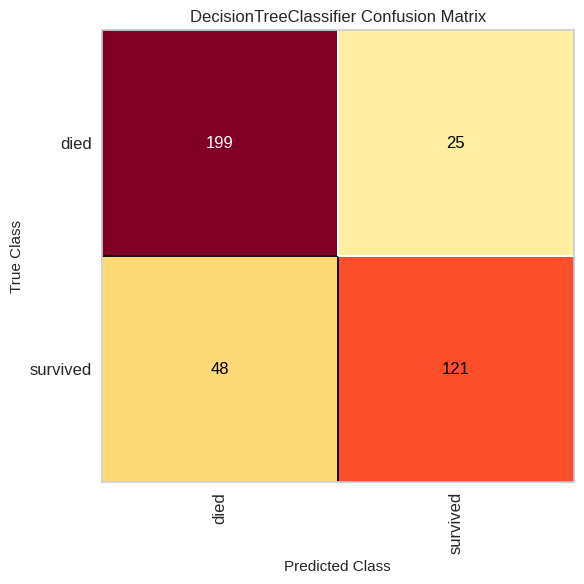

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [7]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix

mapping = {0:"died", 1:"survived"}
fig, ax = plt.subplots(figsize=(6,6))
cm_viz = ConfusionMatrix(
    dt, classes=["died", "survived"],
    label_encoder=mapping
)
cm_viz.score(X_test, y_test)
cm_viz.poof()

In [8]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport

/home/pcmoraes/Área de Trabalho/Editores de código/Inteligencia-Artificial/venv/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


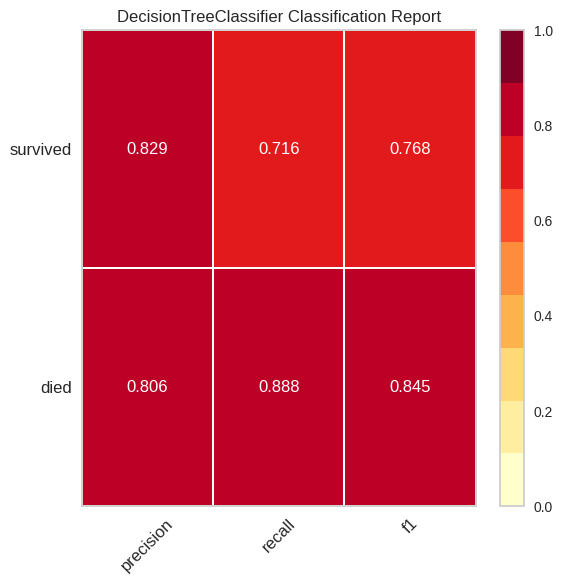

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
cm_viz = ClassificationReport(dt, classes=["died", "survived"], label_encoder=mapping)
cm_viz.score(X_test, y_test)
cm_viz.poof()


In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
y_predict = dt.predict(X_test)
roc_auc_score(y_test, y_predict)

0.8021845942519018

/home/pcmoraes/Área de Trabalho/Editores de código/Inteligencia-Artificial/venv/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


YellowbrickAttributeError: neither visualizer 'ROCAUC' nor wrapped estimator 'DecisionTreeClassifier' have attribute 'target_type_'

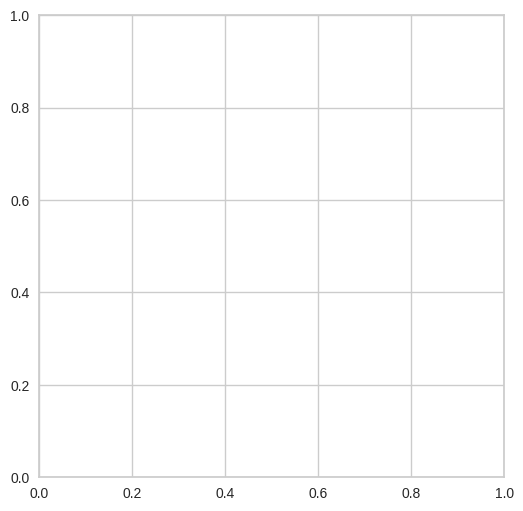

In [18]:
from yellowbrick import ROCAUC
fig, ax = plt.subplots(figsize=(6,6))

roc_viz = ROCAUC(dt)
roc_viz.score(X_test, y_test)
roc_viz.poof()

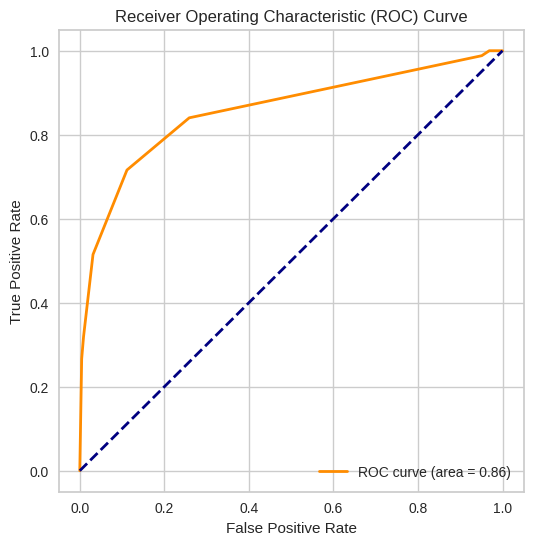

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'dt' is your DecisionTreeClassifier and 'X_test', 'y_test' are your test data
y_scores = dt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [21]:
from sklearn.metrics import average_precision_score

In [22]:
y_predict = dt.predict(X_test)
average_precision_score(y_test, y_predict)

0.7155150490642249

In [23]:
from yellowbrick.classifier import PrecisionRecallCurve

/home/pcmoraes/Área de Trabalho/Editores de código/Inteligencia-Artificial/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


0.8177126373723866

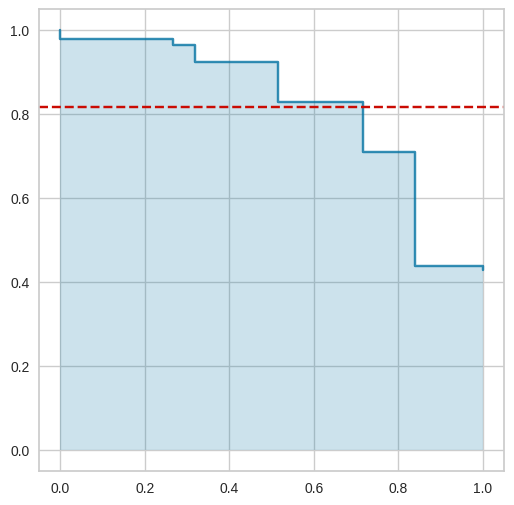

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
viz = PrecisionRecallCurve(dt)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

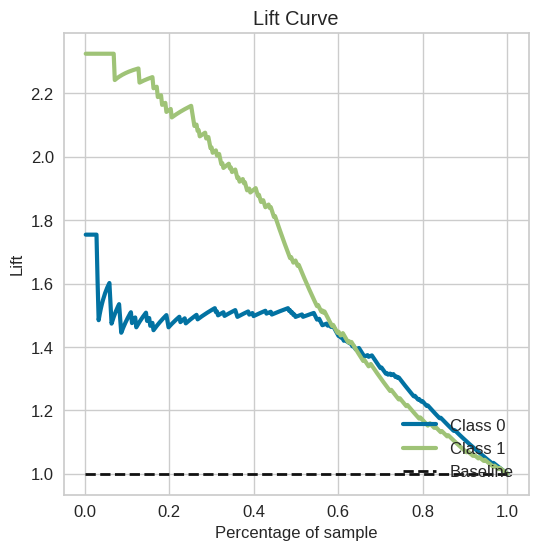

In [29]:
import scikitplot as skplt
fig, ax = plt.subplots(figsize=(6,6))
y_probas = dt.predict_proba(X_test)

skplt.metrics.plot_lift_curve(y_test, y_probas, ax=ax)

In [30]:
from yellowbrick.classifier import ClassBalance

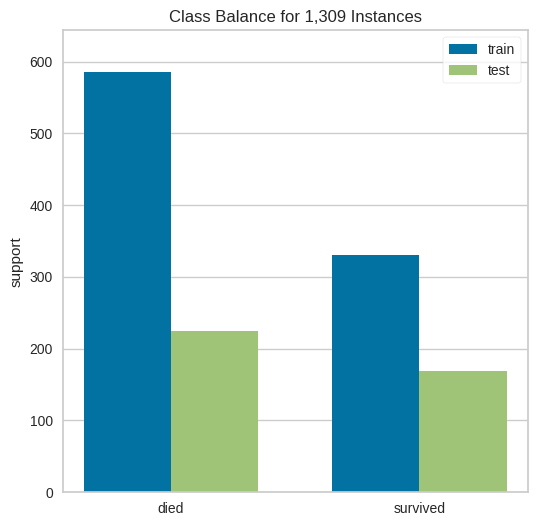

<Axes: title={'center': 'Class Balance for 1,309 Instances'}, ylabel='support'>

In [31]:
fig, ax = plt.subplots(figsize=(6,6))

cb_viz = ClassBalance(
    labels=["died", "survived"]
)
cb_viz.fit(y_train, y_test)
cb_viz.poof()

In [32]:
from yellowbrick.classifier import ClassPredictionError

/home/pcmoraes/Área de Trabalho/Editores de código/Inteligencia-Artificial/venv/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


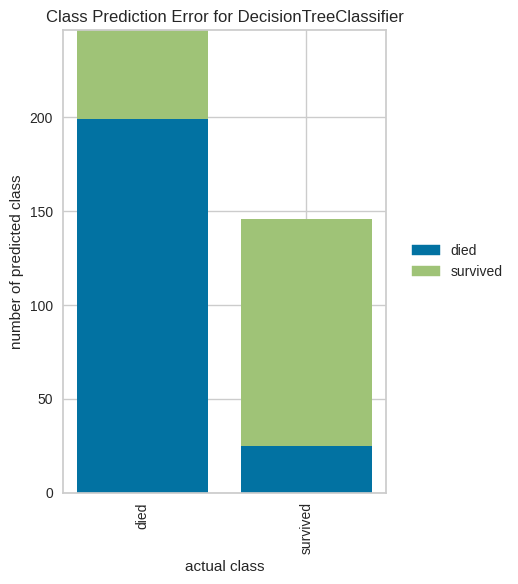

<Axes: title={'center': 'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [33]:
fig, ax = plt.subplots(figsize=(6,6))

cpe_viz = ClassPredictionError(
    dt, classes=["died", "survived"]
)
cpe_viz.score(X_test, y_test)
cpe_viz.poof()

In [34]:
from yellowbrick.classifier import DiscriminationThreshold

/home/pcmoraes/Área de Trabalho/Editores de código/Inteligencia-Artificial/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


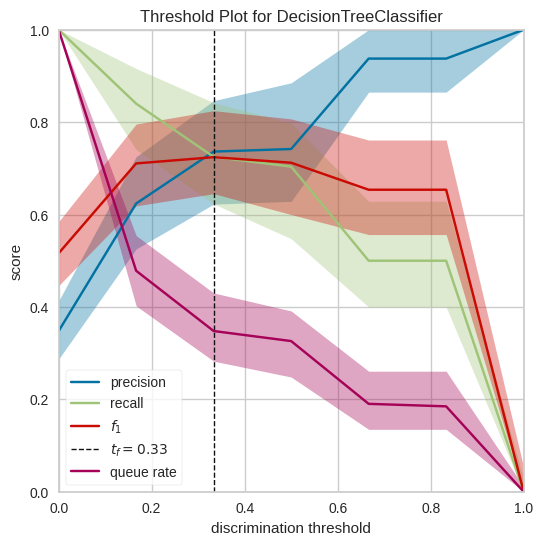

<Axes: title={'center': 'Threshold Plot for DecisionTreeClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [35]:
fig, ax = plt.subplots(figsize=(6,6))

dt_viz = DiscriminationThreshold(dt)
dt_viz.fit(X_train, y_train)
dt_viz.poof()